In [1]:
dataset = "cifar10"
algorithm = "natural"

### 1. Load Dataset

In [2]:
from art.utils import load_cifar10
import numpy as np

(_x1, _y1), (_x2, _y2), _min, _max = load_cifar10()
x = np.concatenate((_x1, _x2))
y = np.concatenate((_y1, _y2))

# Swap axes to PyTorch's NCHW format
x = np.transpose(x, (0, 3, 1, 2)).astype(np.float32)

target_train_size = 2500
target_test_size = 2500
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def cifar_model(): 
    model = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*8*8,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            m.bias.data.zero_()
    return model

summary(cifar_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
              ReLU-4             [-1, 32, 8, 8]               0
           Flatten-5                 [-1, 2048]               0
            Linear-6                  [-1, 100]         204,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 214,918
Trainable params: 214,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.82
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

class PytorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train(dataloader, model, loss_fn, optimizer):
    for batch, (i_batch, o_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        model_outputs = model(i_batch)
        loss = loss_fn(model_outputs, o_batch)
        loss.backward()
        optimizer.step()

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = cifar_model()
train_dataloader = DataLoader(PytorchDataset(x_target_train, y_target_train), batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

nb_epochs = 100
best_acc = 0
for i in tqdm(range(nb_epochs)):
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    test_acc = get_acc(model, x_target_test, y_target_test)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{dataset}_{algorithm}.pth")

# purposedly trained to overfit
# model.load_state_dict(torch.load(f"models/{dataset}_{algorithm}.pth"))
model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]

Train accuracy: 1.0
Test accuracy: 0.4232


### 4. Generate Adversarial Examples using HopSkipJump

In [5]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    clip_values=(_min, _max),
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     0.480345
std      0.248615
min      0.229948
25%      0.309696
50%      0.399258
75%      0.596461
max      1.651680
                0
count  100.000000
mean     0.267604
std      0.303730
min      0.000127
25%      0.070018
50%      0.166280
75%      0.342003
max      1.740674


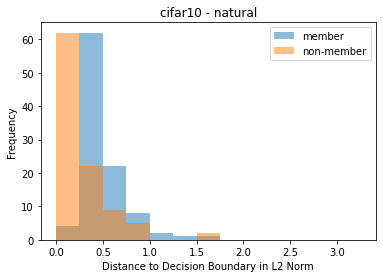

In [9]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.01 0.02 0.02 0.03 0.03 0.05 0.05 0.08 0.08 0.09 0.09 0.1  0.1
 0.13 0.13 0.14 0.14 0.15 0.15 0.16 0.16 0.18 0.18 0.19 0.19 0.2  0.2
 0.21 0.21 0.22 0.22 0.23 0.23 0.24 0.24 0.26 0.26 0.27 0.27 0.28 0.28
 0.31 0.31 0.32 0.32 0.33 0.33 0.34 0.34 0.36 0.36 0.37 0.37 0.38 0.38
 0.39 0.39 0.41 0.41 1.  ]
[0.   0.   0.   0.1  0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.15 0.15 0.17
 0.17 0.22 0.22 0.24 0.24 0.27 0.27 0.38 0.38 0.44 0.44 0.47 0.47 0.57
 0.57 0.58 0.58 0.59 0.59 0.61 0.61 0.62 0.62 0.66 0.66 0.67 0.67 0.71
 0.71 0.81 0.81 0.85 0.85 0.86 0.86 0.9  0.9  0.91 0.91 0.94 0.94 0.96
 0.96 0.98 0.98 1.   1.  ]
[2.7406735e+00 1.7406735e+00 1.6792548e+00 8.2987738e-01 8.1979167e-01
 8.0184108e-01 7.9194880e-01 7.8997093e-01 7.3133993e-01 7.1276718e-01
 7.0329589e-01 6.8725091e-01 6.7483419e-01 6.6727954e-01 6.4752203e-01
 6.1908585e-01 6.1608160e-01 6.0311109e-01 6.0204130e-01 5.8551282e-01
 5.5983454e-01 4.7601596e-01 4.6485838e-01 4.3085149e-01 4.2826089e-01
 4.1674086e-01 4.1144118e

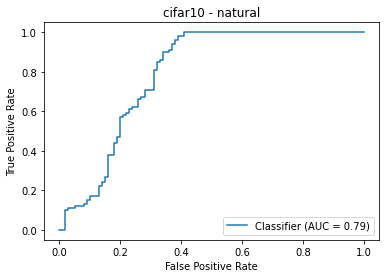

In [10]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [8]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.4739982211398746 6.313553345869942e-07
test correlation  0.5486699574556433 3.4240820251876714e-09
